<a href="https://colab.research.google.com/github/jonatanriq/oceanografia/blob/main/simcosta_autocorrelacao.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

<font size='6'> Análise da Autocorrelação de Hs: RJ-4 SiMCosta
<p> <font size='4'> Autor: <strong> Jonatan Nascimento (jonatanriq) </strong> </font> </p>
<p> <font size='4'> Data: <strong> 14/04/2022 </strong> </font> </p>

<p> <font size='3' > Nesse Notebook vamos avaliar a autocorrelação dos dados de altura significativa para a boia RJ-4 do SiMCosta. A intenção é verificar quais procedimentos são necessários aplicar no dataset para futuras análises! </font> </p>

<p> <font size='3' > Vou verificar também a autocorrelação para velocidade dos ventos e correlacionar com o lag na altura de ondas! </font> </p>

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from statsmodels.graphics.tsaplots import plot_acf

In [2]:
# importanto o dado
dados = pd.read_csv('/content/SIMCOSTA_RJ-4_OCEAN_2017-08-28_2021-11-12.csv', skiprows=21)

In [3]:
# ajustando o dataset
dados.index = pd.to_datetime(dados[['YEAR', 'MONTH', 'DAY', 'HOUR']])
dados = dados[dados.index < '2020']
dados = dados[dados.columns[6:]]
dados

,Hsig,TP,Avg_Wv_Dir,Avg_Wv_Dir_N,Avg_Cel1_Mag,Avg_Cel1_Dir,Avg_Cel1_Dir_N,M_Decl,Tsig
2017-08-28 13:00:00,0.94,8.7,162.0,139.26,17.31,166.80,144.06,-22.74,7.0
2017-08-28 13:00:00,0.96,6.5,163.0,140.26,48.28,151.29,128.55,-22.74,NaN
2017-08-28 14:00:00,0.89,6.1,161.0,138.26,36.87,37.97,15.23,-22.74,NaN
2017-08-28 15:00:00,0.90,10.0,161.0,138.26,49.48,61.31,38.57,-22.74,7.2
2017-08-28 15:00:00,0.91,9.1,164.0,141.26,63.83,76.64,53.90,-22.74,NaN
...,...,...,...,...,...,...,...,...,...
2019-12-31 21:00:00,0.82,4.5,154.0,131.03,68.31,5.49,342.52,-22.97,4.7
2019-12-31 21:00:00,0.86,4.5,156.0,133.03,86.63,312.52,289.55,-22.97,NaN
2019-12-31 22:00:00,0.77,4.9,157.0,134.03,191.36,300.40,277.43,-22.97,4.8
2019-12-31 22:00:00,0.81,5.1,163.0,140.03,202.75,298.31,275.34,-22.97,NaN


<p> <font size='4'> <strong> Visualizando os dados... </strong> </font> </p>

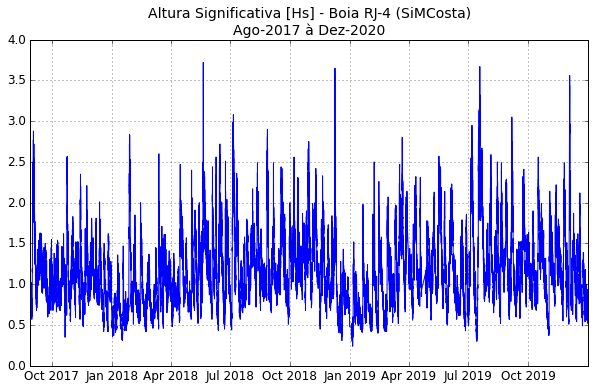

In [4]:
plt.figure(figsize=(10,6))
plt.style.use('classic')
plt.plot(dados.Hsig, linestyle='-')
plt.xlim(dados.index.min(), dados.index.max())
plt.title('Altura Significativa [Hs] - Boia RJ-4 (SiMCosta)\nAgo-2017 à Dez-2020', fontsize=14)
plt.grid()

<p> <strong> Esse plot em si não nos diz muito. Vamos verificar a autocorrelação para observar as tendências da série temporal. <strong> </p>

<Figure size 1920x960 with 0 Axes>

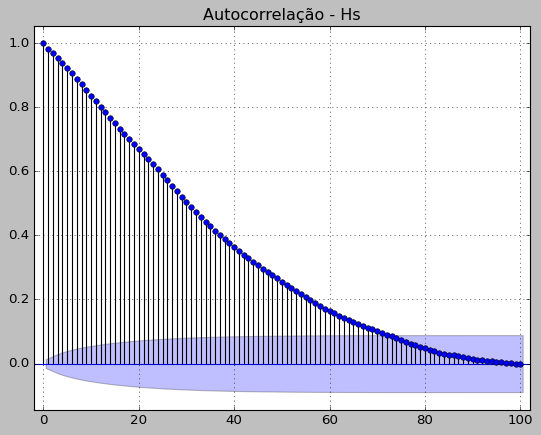

In [57]:
hsig = dados.Hsig.resample('1H').mean().interpolate(method ='linear', limit_direction ='forward')
plt.figure(figsize=(24,12))
plt.style.use('classic')
plot_acf(hsig, lags=100)
plt.xlim(-2,102)
plt.grid(linestyle=':')
plt.title('Autocorrelação - Hs')
plt.show()

<font size='3' > Os primeiros lags, que são relativos às menores escalas de tempo, estão com <font color='red'> <strong> alta autocorrelação positiva. Esse padrão vai até o lag de aproximadamente 72 horas (3 dias). </strong> </font> 

Existe também uma forte tendência dentro do dataset. <font color='red'> <strong> Pode ser o caso de se aplicar um detrend. </strong> </font>

In [49]:
from statsmodels.tsa.seasonal import seasonal_decompose
series = hsig
result = seasonal_decompose(series, model='multiplicative')

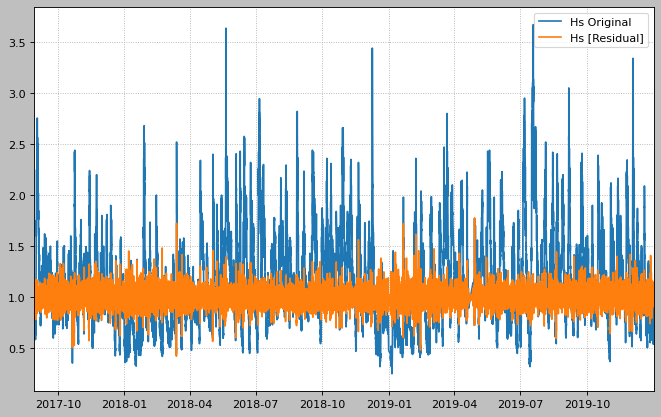

In [50]:
# plotando o resultado do residual
plt.figure(figsize=(10,6))
plt.style.use('default')
plt.plot(hsig, label='Hs Original')
plt.plot(result.resid, label='Hs [Residual]')
plt.grid(linestyle=':')
plt.xlim(result.resid.index.min(),result.resid.index.max())
plt.legend()
plt.show()

<Figure size 1920x960 with 0 Axes>

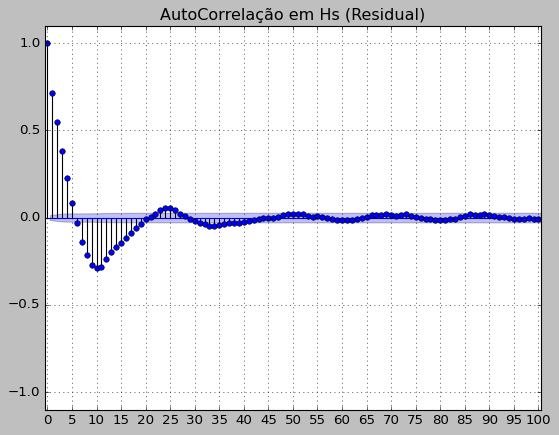

In [58]:
# plotando a autocorrelação para os dados residuais
mask = result.resid.isnull()

plt.figure(figsize=(24,12))
plt.style.use('classic')
plot_acf(result.resid[~mask], lags=100, markerfacecolor='blue')
plt.xlim(-0.5,100.5)
plt.xticks(np.arange(0,101,5))
plt.ylim(-1.1,1.1)
plt.grid(linestyle=':')
plt.title('AutoCorrelação em Hs (Residual)')
plt.show()

O residual deu diferença. Mostra que a partir do lag 20, a autocorrelação deixa de ser significativa!

In [85]:
# criando as funções de autocorrelações...
def autocorr(self, lag=1):
    """
    Lag-N autocorrelation

    Parameters
    ----------
    lag : int, default 1
        Number of lags to apply before performing autocorrelation.

    Returns
    -------
    autocorr : float
    """
    return self.corr(self.shift(lag))

def crosscorr(datax, datay, lag=0):
    """ Lag-N cross correlation. 
    Parameters
    ----------
    lag : int, default 0
    datax, datay : pandas.Series objects of equal length

    Returns
    ----------
    crosscorr : float
    """
    return datax.corr(datay.shift(lag))

<font size='5'> Vamos fazer com os ventos agora! </font>

In [93]:
ventos = pd.read_csv('/content/SIMCOSTA_RJ-4_MET_2017-08-28_2022-04-01.csv', skiprows=21)
ventos.index = pd.to_datetime(ventos[['YEAR', 'MONTH', 'DAY', 'HOUR']])
ventos = ventos[ventos.index < '2020']
ventos = ventos[ventos.columns[6:]]
vel_vento = ventos.Avg_Wnd_Sp.resample('1H').mean().interpolate(method ='linear', limit_direction ='forward')

<Figure size 1920x960 with 0 Axes>

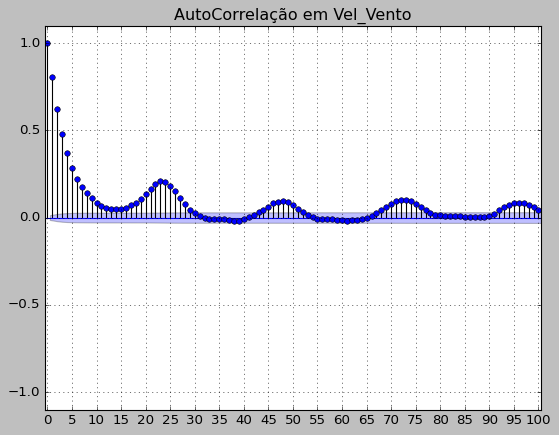

In [95]:
plt.figure(figsize=(24,12))
plt.style.use('classic')
plot_acf(vel_vento, lags=100, markerfacecolor='blue')
plt.xlim(-0.5,100.5)
plt.xticks(np.arange(0,101,5))
plt.ylim(-1.1,1.1)
plt.grid(linestyle=':')
plt.title('AutoCorrelação em Vel_Vento')
plt.show()

Tem bastante sazonalidade! Vamos decompor isso

In [96]:
# decompondo o sinal
result_vento = seasonal_decompose(vel_vento, model='multiplicative')

<Figure size 1920x960 with 0 Axes>

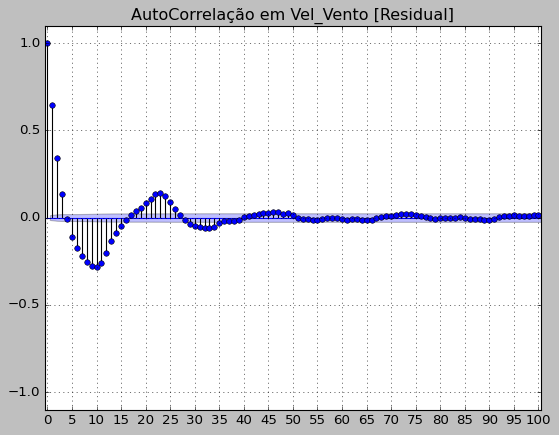

In [99]:
mask = result_vento.resid.isnull()
plt.figure(figsize=(24,12))
plt.style.use('classic')
plot_acf(result_vento.resid[~mask], lags=100, markerfacecolor='blue')
plt.xlim(-0.5,100.5)
plt.xticks(np.arange(0,101,5))
plt.ylim(-1.1,1.1)
plt.grid(linestyle=':')
plt.title('AutoCorrelação em Vel_Vento [Residual]')
plt.show()

<p>Tem uma semelhança com a altura significativa. Vamos realizar um crosscorrelation entre as duas séries! </p>
<br>

<p> <font size='5'> CrossCorrelation </font> </p>

<p> Quero que as direções de ventos e ondas correspondam umas as outras </p>

In [215]:
# criando o dataframe
novo = pd.DataFrame()
novo['vel_vento'] = ventos.Avg_Wnd_Sp.resample('1H').mean().interpolate(method ='linear', limit_direction ='forward')
novo['hsig'] = dados.Hsig.resample('1H').mean().interpolate(method ='linear', limit_direction ='forward')
ventos.Avg_Wnd_Dir_N = ventos.Avg_Wnd_Dir_N.apply(pd.to_numeric, errors='coerce')
novo['dir_vento'] = ventos.Avg_Wnd_Dir_N.resample('1H').mean().interpolate(method ='linear', limit_direction ='forward')
novo['dir_onda'] = dados.Avg_Wv_Dir_N.resample('1H').mean().interpolate(method ='linear', limit_direction ='forward')

# calculando z-score
from scipy import stats
novo['zscore_vel_vento'] = stats.zscore(novo.vel_vento)
novo['zscore_hsig'] = stats.zscore(novo.hsig)

# criando uma máscara
mask = np.sqrt((novo['dir_vento'] - novo['dir_onda'])**2) < 15 # quero que a diferença entre a direção dos ventos e das ondas seja menor que 15 graus
novo = novo[mask]
novo = novo.resample('1H').mean().interpolate(method ='linear', limit_direction ='forward')
novo = novo[(novo.zscore_hsig < 3) & (novo.zscore_vel_vento < 3)]

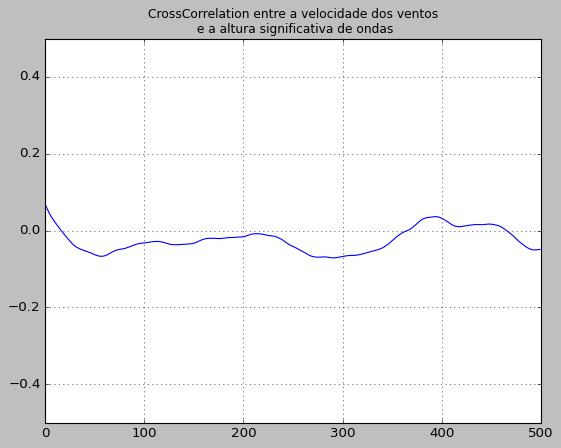

In [219]:
plt.plot([crosscorr(novo.vel_vento, novo.hsig, lag=i) for i in range(500)])
plt.ylim(-0.5,0.5)
plt.grid()
plt.title('CrossCorrelation entre a velocidade dos ventos\n e a altura significativa de ondas', fontsize=11)
plt.show()

<font size='5'> Conclusão </font>

<p> Observa-se então que a correlação cruzada entre a altura significativa de onda e a velocidade do vento é muito baixa. <strong> Portanto, a correlação entre as duas variáveis é insuficiente para ser usada em futuros modelos. Necessita-se de mais dados para criar um modelo de previsão. </strong> </p>